In [1]:
#Run only once
%load_ext autoreload
%autoreload 2

In [3]:
cd ..

/home/DeepLearningMachine/JointAngleMeasurement


In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
from PIL import Image, ImageOps
import cv2 as cv
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import itertools
from src.helper_functions import *

In [6]:
train_path = 'data/Poses/train'
valid_path = 'data/Poses/valid'
test_path = 'data/Poses/test'

In [7]:
#Load in images and place them into training batches
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224, 224), classes=['squatting', 'bending', 'raising_shoulders'], batch_size=9)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224, 224), classes=['squatting', 'bending', 'raising_shoulders'], batch_size=9)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224, 224), classes=['squatting', 'bending', 'raising_shoulders'], batch_size=10)

Found 207 images belonging to 3 classes.
Found 54 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [8]:
imgs, labels = next(train_batches)

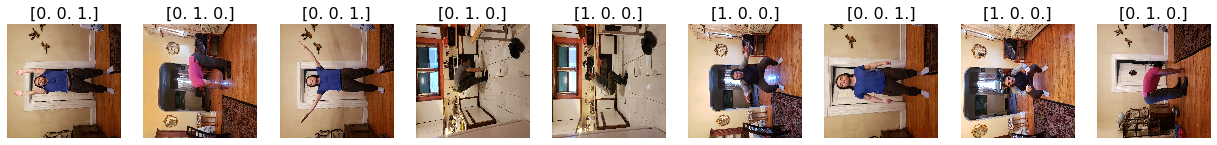

In [9]:
plots(imgs, titles=labels)

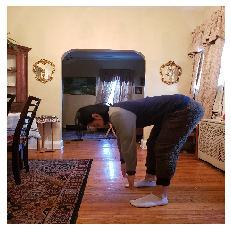

In [10]:
bending_img = cv.imread('data/Poses/train/bending/20200511_190442.jpg')
bending_img = cv.resize(bending_img, (244, 244))
plt.axis('off')
plt.imshow(cv.cvtColor(bending_img, cv.COLOR_BGR2RGB))
plt.show()

In [60]:
vgg16_model = tf.keras.applications.vgg16.VGG16()


In [61]:
#Make Sequential Model out of Base VGG16 Model
Pose_Analyzer_Model = Sequential()
for layer in vgg16_model.layers[:-1]:
    Pose_Analyzer_Model.add(layer)

In [62]:
#Freeze layers that have already been trained
for layer in Pose_Analyzer_Model.layers[:-2]:
    layer.trainable = False

In [63]:
#Add final dense layer to predict our classes: Squat, Bending Over, Hands over head
num_classes = 3
Pose_Analyzer_Model.add(Dense(3, activation='softmax'))

In [64]:
Pose_Analyzer_Model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [65]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [66]:
Pose_Analyzer_Model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [67]:
Pose_Analyzer_Model.fit_generator(train_batches, steps_per_epoch=23, validation_data=valid_batches, validation_steps=6, epochs=30, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 23 steps, validate for 6 steps
Epoch 1/30
23/23 - 22s - loss: 0.8258 - accuracy: 0.8019 - val_loss: 0.3891 - val_accuracy: 0.8889
Epoch 2/30
23/23 - 22s - loss: 0.0788 - accuracy: 0.9662 - val_loss: 0.4696 - val_accuracy: 0.9074
Epoch 3/30
23/23 - 22s - loss: 6.1682e-04 - accuracy: 1.0000 - val_loss: 0.5169 - val_accuracy: 0.9630
Epoch 4/30
23/23 - 22s - loss: 8.5232e-06 - accuracy: 1.0000 - val_loss: 0.5107 - val_accuracy: 0.9444
Epoch 5/30
23/23 - 22s - loss: 5.2693e-07 - accuracy: 1.0000 - val_loss: 0.4558 - val_accuracy: 0.9630
Epoch 6/30
23/23 - 22s - loss: 4.6071e-08 - accuracy: 1.0000 - val_loss: 0.4499 - val_accuracy: 0.9630
Epoch 7/30
23/23 - 22s - loss: 3.8585e-08 - accuracy: 1.0000 - val_loss: 0.4487 - val_accuracy: 0.9630
Epoch 8/30
23/23 - 22s - loss: 3.6281e-08 - accuracy: 1.0000 - val_loss: 0.4482 - val_accuracy: 0.9630
Epoch 9/30
23/23 - 22s - loss: 3.2250e-08 - accuracy: 1.0000 - val_loss: 0.4476 - val_accurac

In [70]:
test_imgs, test_labels = next(test_batches)

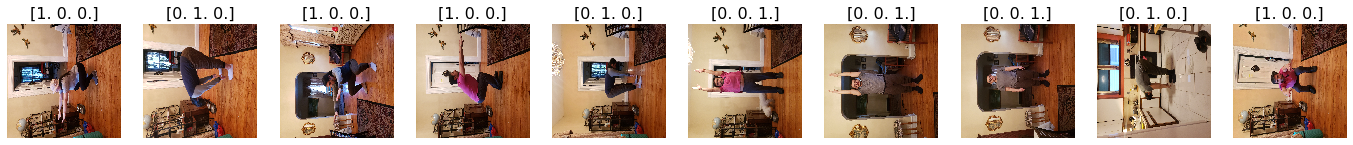

In [71]:
plots(test_imgs, titles=test_labels)

In [72]:
predictions = Pose_Analyzer_Model.predict_generator(test_batches, steps=3, verbose=0)

Instructions for updating:
Please use Model.predict, which supports generators.


In [100]:
df_cm = pd.DataFrame(predictions)

In [105]:
df_cm['Prediction'].iloc[3] = 0
df_cm

,0,1,2,Prediction
0,1.000000e+00,7.342499e-22,6.036217e-33,Sin
1,4.663784e-08,1.000000e+00,8.094285e-18,Sin
2,1.000000e+00,1.832094e-18,1.139629e-31,Sin
3,1.000000e+00,1.804945e-12,6.360873e-24,0
4,3.323621e-06,9.999967e-01,2.863220e-12,Sin
5,9.187174e-21,1.434512e-15,1.000000e+00,Sin
6,3.451786e-22,2.064910e-22,1.000000e+00,Sin
7,2.465626e-17,4.333420e-17,1.000000e+00,Sin
8,1.312430e-04,9.998688e-01,8.555962e-10,Sin
9,1.000000e+00,1.441553e-14,7.794566e-26,Sin


In [89]:
for i in df_cm.index:
    df_cm['Prediction'] = 'Sin' 

In [99]:
df_cm

'Never'

In [79]:
import seaborn as sn

In [80]:
df_cm = pd.DataFrame(predictions)

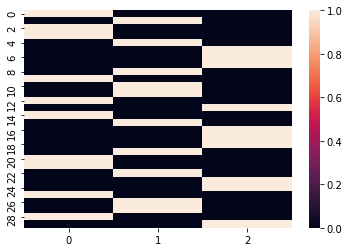

In [81]:
sn.heatmap(df_cm)
plt.show()

In [74]:
from sklearn.metrics import plot_confusion_matrix

ValueError: plot_confusion_matrix only supports classifiers